#Function develop design and test

Variogram map


In [1]:
%matplotlib inline
import pygslib as gslib      

gslib.version

<function pygslib.version>

In [2]:
# we read the file header
# use >>> print. gslib.read_header.__doc__ for help

#the data file is in the working directory
mydata= gslib.read_gslib_file('../datasets/cluster.dat') 

#adding elevation and a dummy BHID
mydata['Zlocation']=0
mydata['bhid']=1


print ' \n **** 5 first rows in my datafile \n\n  ', mydata.head(n=5)

 
 **** 5 first rows in my datafile 

      Xlocation  Ylocation  Primary  Secondary  Declustering Weight  Zlocation  \
0       39.5       18.5     0.06       0.22                1.619          0   
1        5.5        1.5     0.06       0.27                1.619          0   
2       38.5        5.5     0.08       0.40                1.416          0   
3       20.5        1.5     0.09       0.39                1.821          0   
4       27.5       14.5     0.09       0.24                1.349          0   

   bhid  
0     1  
1     1  
2     1  
3     1  
4     1  


## Defining and plotting direction over a plane

In [3]:
#define a direction:
import numpy as np
import matplotlib.pyplot as plt

def hdir(r=1, ndir=18, refdir=0):
    theta = np.linspace(0, np.pi, ndir+1)[:-1]
    ax = plt.subplot(111, polar=True)
    
    # make clockwise like maps
    ax.set_theta_direction(-1)
    # make the plot to point north 
    ax.set_theta_zero_location("N")

    for t in theta: 
        pass
        ax.plot([0,t], [0,r], color='r', linewidth=1)
        ax.plot([0,t+np.pi], [0,r], color='r', linewidth=1)

    ax.grid(True)

    
    ax.invert_yaxis()
    ax.set_title("A line plot on a polar axis", va='bottom')
    
    
    ax.plot([0,refdir], [0,r], color='b', linewidth=3)
    ax.plot([0,refdir+np.pi], [0,r], color='b', linewidth=3)

    plt.show()
    
    
    return np.rad2deg(theta) #the last direction 
    

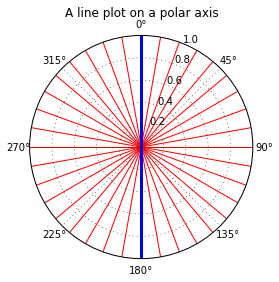

18 [   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.]


In [4]:
azm= hdir(r=1, ndir=18, refdir=0)
print len (azm), azm

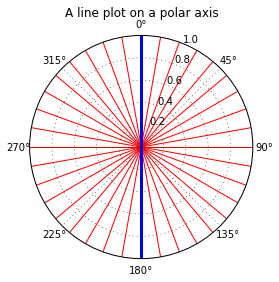

In [5]:
ndir=18
azm= hdir(r=1, ndir=ndir, refdir=0)  #this produces a plot + directions
atol= np.ones(ndir)*180/ndir/2
dip = np.zeros(ndir)
bandwh = np.ones(ndir)*5000
bandwd = np.ones(ndir)*5000
dtol = np.ones(ndir)*5000
sills = [np.var(mydata['Primary'])]
ivtail = np.ones(ndir)
ivhead = np.ones(ndir)
ivtype = np.ones(ndir)*7


parameters = { 
'x'      :  mydata['Xlocation']   , # X coordinates, array('f') with bounds (nd), nd is number of data points
'y'      :  mydata['Ylocation'],    # Y coordinates, array('f') with bounds (nd)
'z'      :  mydata['Zlocation'],    # Z coordinates, array('f') with bounds (nd)
'bhid'   :  mydata['bhid'],         # bhid for downhole variogram, array('i') with bounds (nd)    
'vr'     :  mydata['Primary'],      # Variables, array('f') with bounds (nd,nv), nv is number of variables
'tmin'   : -1.0e21,                 # trimming limits, float
'tmax'   :  1.0e21,                 # trimming limits, float
'nlag'   :  8,                     # number of lags, int
'xlag'   :  6,                      # lag separation distance, float                
'xltol'  :  3,                      # lag tolerance, float
'azm'    : azm,                     # azimuth, array('f') with bounds (ndir)
'atol'   : atol,                    # azimuth tolerance, array('f') with bounds (ndir)
'bandwh' : bandwh,                  # bandwith h, array('f') with bounds (ndir)
'dip'    : dip,                     # dip, array('f') with bounds (ndir)
'dtol'   : dtol,              # dip tolerance, array('f') with bounds (ndir)
'bandwd' : bandwd,              # bandwith dip, array('f') with bounds (ndir)
'isill'  : 0,                       # standardize sills? (0=no, 1=yes), int
'sills'  : sills,                   # variance used to std the sills, array('f') with bounds (nv)
'ivtail' : ivtail,         # tail var., array('i') with bounds (nvarg), nvarg is number of variograms
'ivhead' : ivhead,         # head var., array('i') with bounds (nvarg)
'ivtype' : ivtype,         # variogram type, array('i') with bounds (nvarg)
'maxclp' : 50000}                   # maximum number of variogram point cloud to use, input int

In [6]:
#Now we are ready to calculate the variogram
pdis,pgam, phm,ptm,phv,ptv,pnump, cldi, cldj, cldg, cldh = gslib.gamv(parameters)

In [7]:
#get parameters
print type(pdis), pdis.shape

# for example
nvrg = pdis.shape[0]
ndir = pdis.shape[1]
nlag = pdis.shape[2]-2


<type 'numpy.ndarray'> (18, 18, 10)


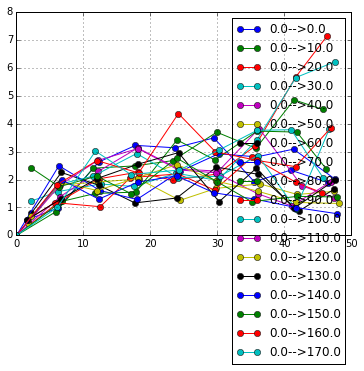

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# knowing that this data is stored in a 3D matrix (nvarg, ndir, nlag+2)

#plot variogram 1 , direction 1,2,3

v=1

ndir

for d in range(ndir):
    dip=parameters['dip'][d]
    azm=parameters['azm'][d]
    plt.plot (pdis[v, d, 1:], pgam[v, d, 1:], '-o', label=str(dip) + '-->' + str(azm))

plt.legend()
plt.grid(True)

plt.show()

#Variogram map
 

 > **Warning:** remove undefined lags (replace zero with nan?)



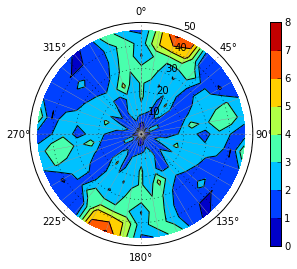

In [9]:
import numpy as np
import matplotlib.pyplot as plt

#get an array of direction + complementary direction = direction + 180
ndir2= len(parameters['azm'])*2
azimuths = np.zeros (ndir2 + 1) #this is to repeat the first direction
zeniths = pdis[0, 0, 1:]
values = np.zeros ((ndir2 +1  ,len(pdis[0, 0, 1:])))

for i in range (ndir2/2):
    azimuths[i] = parameters['azm'][i]
    azimuths[i+ndir2/2] = parameters['azm'][i]+180
    for ii in range(len(pdis[0, 0, 1:])):
        values[i,ii] = pgam[0, i, ii+1]
        values[i+ndir2/2,ii] = pgam[0, i, ii+1]        

azimuths[ndir2] = azimuths[ndir2/2]+180
values[ndir2,:] = values[0,:]
        
#prepare grid        
r, theta = np.meshgrid(zeniths, azimuths)

#-- Plot... ------------------------------------------------
ax = plt.subplot(111, polar=True)
# make clockwise like maps
ax.set_theta_direction(-1)
# make the plot to point north 
ax.set_theta_zero_location("N")
cont=ax.contourf(np.deg2rad(theta), r, values)
ax.contour(np.deg2rad(theta), r, values, colors='k')
ax.plot(np.deg2rad(theta.flatten()), r.flatten(), color= '0.6', linewidth=0.2)
ax.set_rmax(50)
plt.colorbar(cont)
plt.show() 


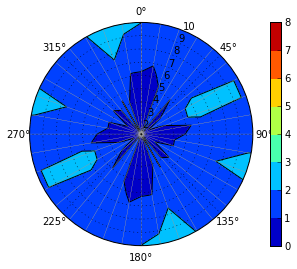

In [10]:
#-- Plot... with zoom ------------------------------------------------
ax = plt.subplot(111, polar=True)
# make clockwise like maps
ax.set_theta_direction(-1)
# make the plot to point north 
ax.set_theta_zero_location("N")
cont=ax.contourf(np.deg2rad(theta), r, values)
ax.contour(np.deg2rad(theta), r, values, colors='k')
ax.plot(np.deg2rad(theta.flatten()), r.flatten(), color= '0.6', linewidth=0.2)
ax.set_rmax(10)
plt.colorbar(cont)
plt.show()